# CNN for text classification handout
## [COSC 7336 Advanced Natural Language Processing](https://fagonzalezo.github.io/dl-tau-2017-2/)

In [98]:
import numpy as np

from IPython.display import SVG
from os.path import join, exists, split
import os

from gensim.models import word2vec, KeyedVectors

# Usa SIEMPRE tensorflow.keras, no keras puro
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, MaxPooling1D, Conv1D, Embedding, GlobalMaxPooling1D, Concatenate
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import plot_model

We will build the model presented in [Kim2014] using Keras. The code is based on the code from Alexander Rakhlin (https://github.com/alexander-rakhlin/CNN-for-Sentence-Classification-in-Keras). 

The model is depicted in the next figure:

[Kim2014] Kim, Y. (2014). [Convolutional neural networks for sentence classification](https://arxiv.org/abs/1408.5882). arXiv preprint arXiv:1408.5882

![CNN model](kim2014cnn.jpg "cnn model")

First we define some general parameters

In [99]:
# 0 Some code goes here

We will use the the IMDB dataset provided by Keras. However, we will use only 1500 samples for training and 10000 for testing. 

In [100]:
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_words, start_char=1, oov_char=2, index_from=3)
print("Original x_train length:", len(x_train))
print("Original x_test length:", len(x_test))
x_train = x_train[:100]
y_train = y_train[:100]
x_test = x_test[:10000]
y_test = y_test[:10000]

x_train = sequence.pad_sequences(x_train, maxlen=sequence_length, padding="post", truncating="post")
x_test = sequence.pad_sequences(x_test, maxlen=sequence_length, padding="post", truncating="post")

vocabulary = imdb.get_word_index()
vocabulary_inv = dict((v, k) for k, v in vocabulary.items())
vocabulary_inv[0] = "<PAD/>"

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("Vocabulary Size: {:d}".format(len(vocabulary_inv)))


Original x_train length: 25000
Original x_test length: 25000
x_train shape: (5000, 20)
x_test shape: (10000, 20)
Vocabulary Size: 88585


In [101]:
vocabulary_inv[2]

'and'

As described in the paper, one of the models uses a pretrained word2vec model to initialize the weights of the embedding layer. The pretrained model can be obtained from: https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing

In [102]:
embedding_model = KeyedVectors.load_word2vec_format('GNvectors.bin', binary=True)
embedding_weights = {key: embedding_model[word] if word in embedding_model else
                          np.random.uniform(-0.5, 0.5, embedding_model.vector_size)
                     for key, word in vocabulary_inv.items()}

In [103]:
embedding_model["table"]

array([-0.14453125, -0.02648926,  0.11767578,  0.21386719, -0.04223633,
       -0.02514648,  0.12207031, -0.20410156,  0.03662109,  0.265625  ,
       -0.08154297, -0.16699219,  0.2109375 , -0.08105469, -0.10498047,
        0.20898438,  0.10449219, -0.05004883,  0.20800781, -0.05566406,
        0.20996094,  0.13964844, -0.14648438, -0.06982422,  0.06103516,
        0.1484375 , -0.1875    ,  0.04321289, -0.11474609, -0.06445312,
       -0.22460938,  0.15527344,  0.00662231,  0.14257812, -0.04370117,
       -0.11132812, -0.11767578,  0.20507812, -0.08789062, -0.20996094,
       -0.07275391, -0.15136719,  0.06640625, -0.07080078,  0.19433594,
       -0.04736328, -0.00352478,  0.02539062,  0.13574219,  0.08740234,
       -0.24023438, -0.01757812, -0.08740234, -0.38867188, -0.13183594,
       -0.09472656,  0.20996094, -0.00518799,  0.16699219,  0.03588867,
       -0.31054688, -0.125     , -0.4140625 , -0.00738525,  0.10058594,
       -0.0546875 , -0.04614258, -0.06494141,  0.14453125, -0.13

## CNN-rand 

The first model we will try is where all words are randomly initialized and then modified during training.

In [104]:
# 1 Some Code Goes Here

We can visualize the structure of the model:

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 20, 300)      26575500    ['input_13[0][0]']               
                                                                                                  
 conv1d_36 (Conv1D)             (None, 18, 100)      90100       ['embedding[0][0]']              
                                                                                                  
 conv1d_37 (Conv1D)             (None, 17, 100)      120100      ['embedding[0][0]']              
                                                                                           

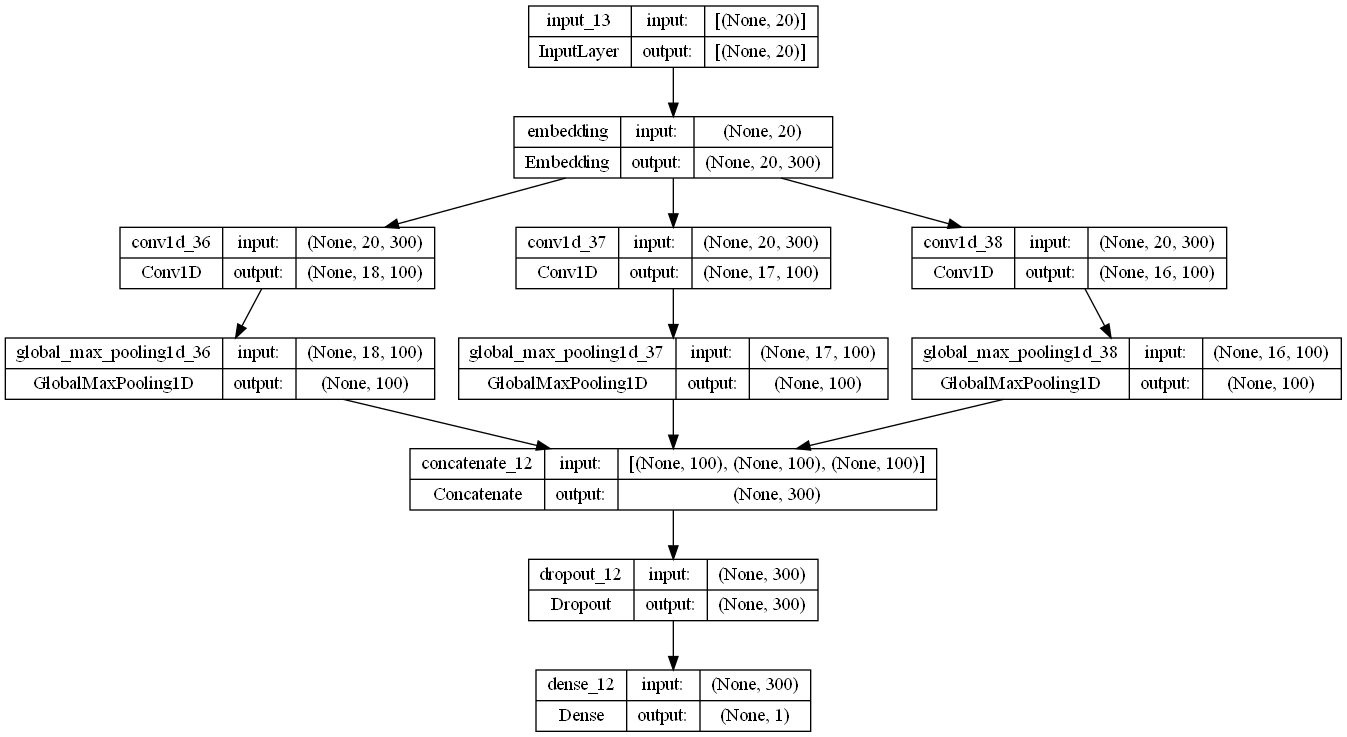

In [105]:
#from keras.utils.vis_utils import model_to_dot
from IPython.display import Image
model_rand.summary()
#SVG(model_to_dot(model_rand, show_shapes=True).create(prog='dot', format='svg'))

# Guarda el modelo como imagen
plot_model(model_rand, to_file="model_rand.png", show_shapes=True)

# Muestra la imagen dentro del notebook
Image("model_rand.png")

Now we are ready to train the model:

In [106]:
num_epochs = 10
history_rand = model_rand.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs,
          validation_data=(x_test, y_test), verbose=2)

Epoch 1/10
79/79 - 9s - loss: 0.6704 - accuracy: 0.5722 - val_loss: 0.6294 - val_accuracy: 0.6497 - 9s/epoch - 108ms/step
Epoch 2/10
79/79 - 7s - loss: 0.5200 - accuracy: 0.7678 - val_loss: 0.5940 - val_accuracy: 0.6721 - 7s/epoch - 85ms/step
Epoch 3/10
79/79 - 7s - loss: 0.3363 - accuracy: 0.8692 - val_loss: 0.6948 - val_accuracy: 0.6558 - 7s/epoch - 86ms/step
Epoch 4/10
79/79 - 7s - loss: 0.1895 - accuracy: 0.9404 - val_loss: 0.8554 - val_accuracy: 0.6509 - 7s/epoch - 86ms/step
Epoch 5/10
79/79 - 7s - loss: 0.0981 - accuracy: 0.9764 - val_loss: 1.0278 - val_accuracy: 0.6467 - 7s/epoch - 86ms/step
Epoch 6/10
79/79 - 7s - loss: 0.0426 - accuracy: 0.9948 - val_loss: 1.2219 - val_accuracy: 0.6399 - 7s/epoch - 86ms/step
Epoch 7/10
79/79 - 7s - loss: 0.0186 - accuracy: 0.9988 - val_loss: 1.3857 - val_accuracy: 0.6390 - 7s/epoch - 84ms/step
Epoch 8/10
79/79 - 7s - loss: 0.0098 - accuracy: 1.0000 - val_loss: 1.5314 - val_accuracy: 0.6394 - 7s/epoch - 86ms/step
Epoch 9/10
79/79 - 7s - loss: 0

We can visualize the evolution of loss and accuracy for both the training and validation sets:

In [107]:
print(history_rand.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [108]:
import matplotlib
matplotlib.use('Agg')  # usa backend sin GUI (seguro)

import matplotlib.pyplot as pl

# Datos simples
x = [0, 1, 2, 3, 4]
y = [0, 1, 4, 9, 16]

# Graficar y guardar sin mostrar
pl.plot(x, y, label="y = x²")
pl.xlabel("x")
pl.ylabel("y")
pl.title("Prueba rápida de plot")
pl.legend()
pl.grid(True)
pl.savefig("test_plot.png")

print("✅ Gráfico guardado como test_plot.png")


✅ Gráfico guardado como test_plot.png


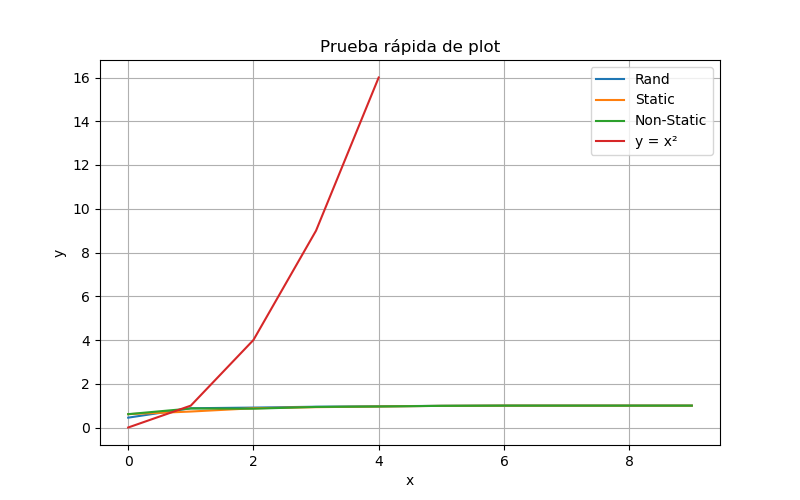

In [109]:
from IPython.display import Image
Image("test_plot.png")

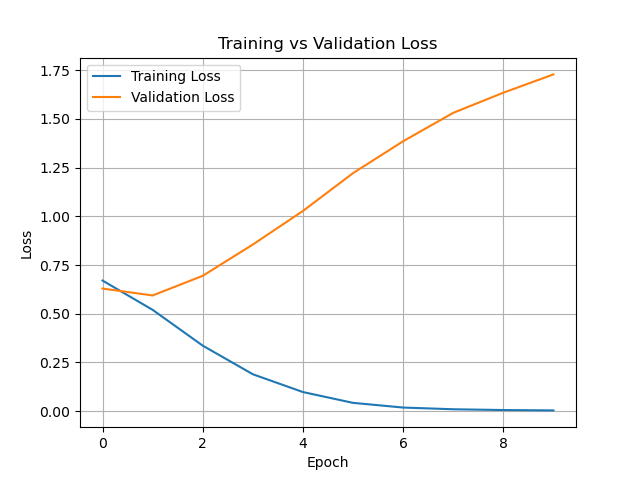

In [110]:
import matplotlib
matplotlib.use('Agg')  # usa backend sin GUI (seguro)

import matplotlib.pyplot as plt

loss = history_rand.history['loss']
val_loss = history_rand.history['val_loss']
plt.figure()

plt.plot(loss, label='Training Loss')

plt.plot(val_loss, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')


plt.grid(True)

# En lugar de usar legend() que renderiza en vivo, lo guardamos
plt.legend()
plt.savefig("loss_with_legend.png")
from IPython.display import Image
Image("loss_with_legend.png")

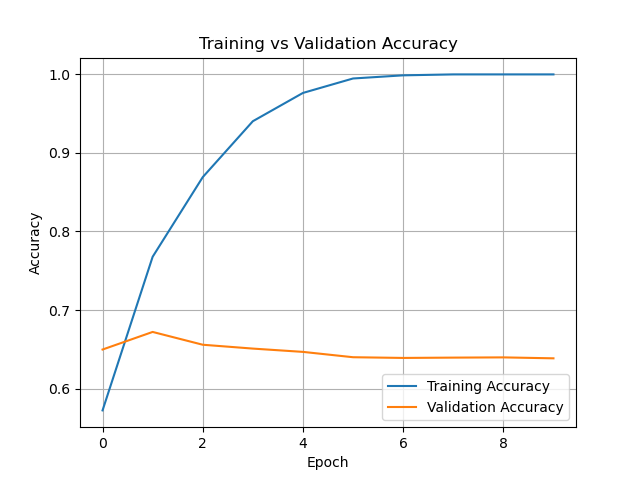

In [111]:
import matplotlib
matplotlib.use('Agg')  # usa backend sin GUI (seguro)

import matplotlib.pyplot as plt

acc = history_rand.history['accuracy']
val_acc = history_rand.history['val_accuracy']

plt.figure()
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.grid(True)
plt.legend()

plt.savefig("accuracy_with_legend.png")
from IPython.display import Image
Image("accuracy_with_legend.png")

## CNN-static

This model uses word2vec vectors to initialize the embedding. The weights of the embedding are kept fixed so they are not modified by training.

In [112]:
# Some Code Goes Here

Initializing embedding layer with word2vec weights, shape (88585, 300)


In [113]:
model_static.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 20)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 20, 300)      26575500    ['input_14[0][0]']               
                                                                                                  
 conv1d_39 (Conv1D)             (None, 18, 100)      90100       ['embedding[0][0]']              
                                                                                                  
 conv1d_40 (Conv1D)             (None, 17, 100)      120100      ['embedding[0][0]']              
                                                                                           

In [114]:
num_epochs = 10
history_static = model_static.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs,
          validation_data=(x_test, y_test), verbose=2)

Epoch 1/10
79/79 - 4s - loss: 0.7061 - accuracy: 0.5296 - val_loss: 0.6933 - val_accuracy: 0.5394 - 4s/epoch - 47ms/step
Epoch 2/10
79/79 - 2s - loss: 0.6178 - accuracy: 0.6624 - val_loss: 0.6653 - val_accuracy: 0.5831 - 2s/epoch - 26ms/step
Epoch 3/10
79/79 - 2s - loss: 0.5416 - accuracy: 0.7594 - val_loss: 0.6746 - val_accuracy: 0.5778 - 2s/epoch - 24ms/step
Epoch 4/10
79/79 - 2s - loss: 0.4742 - accuracy: 0.8238 - val_loss: 0.6721 - val_accuracy: 0.5838 - 2s/epoch - 24ms/step
Epoch 5/10
79/79 - 2s - loss: 0.4058 - accuracy: 0.8630 - val_loss: 0.6607 - val_accuracy: 0.6077 - 2s/epoch - 23ms/step
Epoch 6/10
79/79 - 2s - loss: 0.3250 - accuracy: 0.9248 - val_loss: 0.6747 - val_accuracy: 0.6097 - 2s/epoch - 25ms/step
Epoch 7/10
79/79 - 2s - loss: 0.2605 - accuracy: 0.9492 - val_loss: 0.6839 - val_accuracy: 0.6036 - 2s/epoch - 27ms/step
Epoch 8/10
79/79 - 2s - loss: 0.2007 - accuracy: 0.9758 - val_loss: 0.7226 - val_accuracy: 0.6042 - 2s/epoch - 30ms/step
Epoch 9/10
79/79 - 2s - loss: 0.

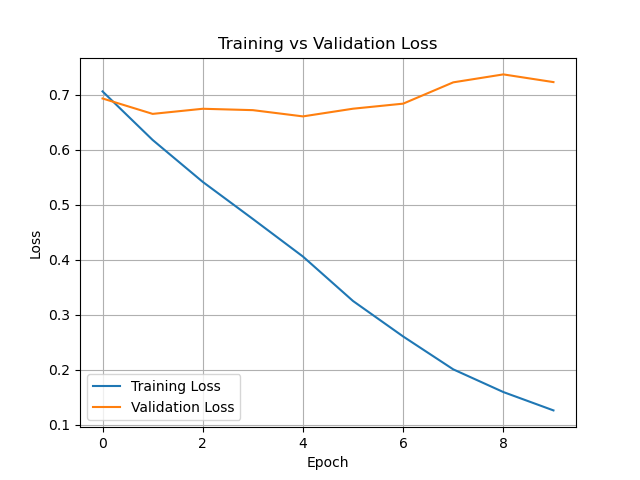

In [115]:
import matplotlib
matplotlib.use('Agg')  # usa backend sin GUI (seguro)

import matplotlib.pyplot as plt

loss = history_static.history['loss']
val_loss = history_static.history['val_loss']

plt.figure()
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.grid(True)

# En lugar de usar legend() que renderiza en vivo, lo guardamos
plt.legend()
plt.savefig("loss_with_legend.png")

from IPython.display import Image
Image("loss_with_legend.png")

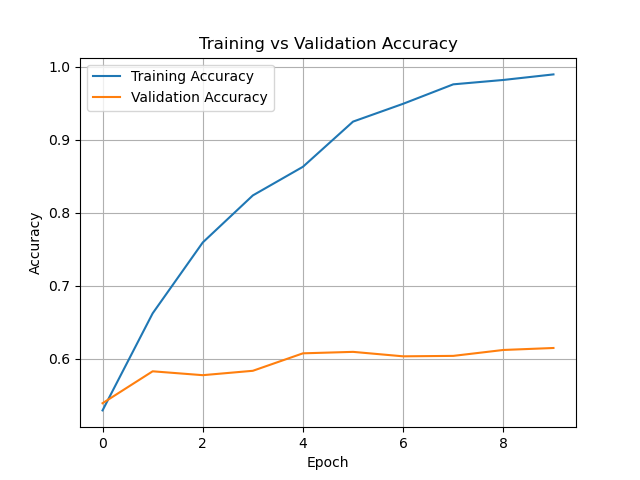

In [116]:
import matplotlib
matplotlib.use('Agg')  # usa backend sin GUI (seguro)

import matplotlib.pyplot as plt

acc = history_static.history['accuracy']
val_acc = history_static.history['val_accuracy']

plt.figure()
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.grid(True)
plt.legend()

plt.savefig("accuracy_with_legend.png")
from IPython.display import Image
Image("accuracy_with_legend.png")

## CNN-non-static

This model is same as the previous one, but the embedding weights are allowed to change during training.

In [117]:
# 3 Some Code Goes Here

Initializing embedding layer with word2vec weights, shape (88585, 300)


In [118]:
num_epochs = 10
history_non_static = model_non_static.fit(x_train, y_train, batch_size=batch_size, epochs=num_epochs,
          validation_data=(x_test, y_test), verbose=2)

Epoch 1/10
79/79 - 10s - loss: 0.6953 - accuracy: 0.5422 - val_loss: 0.6935 - val_accuracy: 0.5400 - 10s/epoch - 123ms/step
Epoch 2/10
79/79 - 8s - loss: 0.5539 - accuracy: 0.7354 - val_loss: 0.6302 - val_accuracy: 0.6349 - 8s/epoch - 107ms/step
Epoch 3/10
79/79 - 9s - loss: 0.4016 - accuracy: 0.8528 - val_loss: 0.6494 - val_accuracy: 0.6371 - 9s/epoch - 116ms/step
Epoch 4/10
79/79 - 10s - loss: 0.2526 - accuracy: 0.9308 - val_loss: 0.6794 - val_accuracy: 0.6434 - 10s/epoch - 126ms/step
Epoch 5/10
79/79 - 12s - loss: 0.1567 - accuracy: 0.9676 - val_loss: 0.7297 - val_accuracy: 0.6481 - 12s/epoch - 150ms/step
Epoch 6/10
79/79 - 15s - loss: 0.0939 - accuracy: 0.9870 - val_loss: 0.8123 - val_accuracy: 0.6499 - 15s/epoch - 191ms/step
Epoch 7/10
79/79 - 22s - loss: 0.0497 - accuracy: 0.9974 - val_loss: 0.8762 - val_accuracy: 0.6501 - 22s/epoch - 281ms/step
Epoch 8/10
79/79 - 36s - loss: 0.0286 - accuracy: 0.9996 - val_loss: 0.9458 - val_accuracy: 0.6486 - 36s/epoch - 460ms/step
Epoch 9/10
7

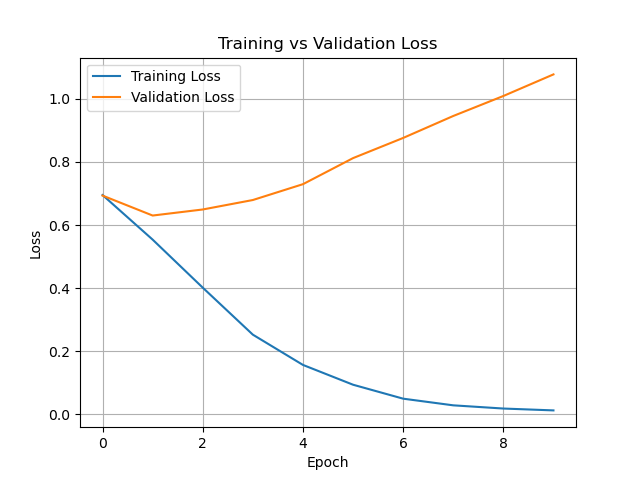

In [119]:
import matplotlib
matplotlib.use('Agg')  # usa backend sin GUI (seguro)

import matplotlib.pyplot as plt

loss = history_non_static.history['loss']
val_loss = history_non_static.history['val_loss']

plt.figure()
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.grid(True)

# En lugar de usar legend() que renderiza en vivo, lo guardamos
plt.legend()
plt.savefig("loss_with_legend.png")

from IPython.display import Image
Image("loss_with_legend.png")

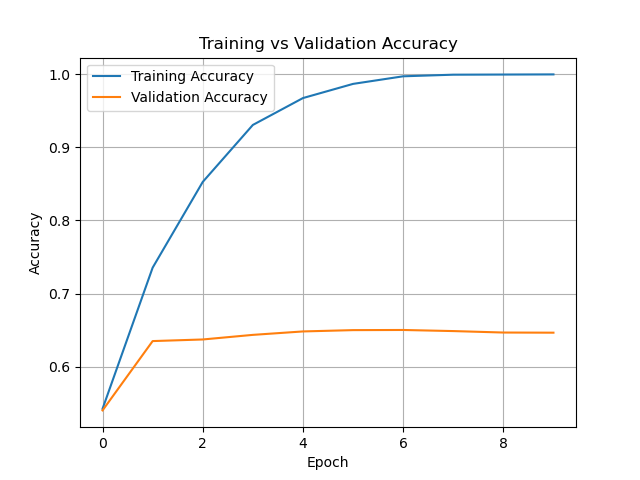

In [120]:
import matplotlib
matplotlib.use('Agg')  # usa backend sin GUI (seguro)

import matplotlib.pyplot as plt

acc = history_non_static.history['accuracy']
val_acc = history_non_static.history['val_accuracy']

plt.figure()
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.grid(True)
plt.legend()

plt.savefig("accuracy_with_legend.png")
from IPython.display import Image
Image("accuracy_with_legend.png")

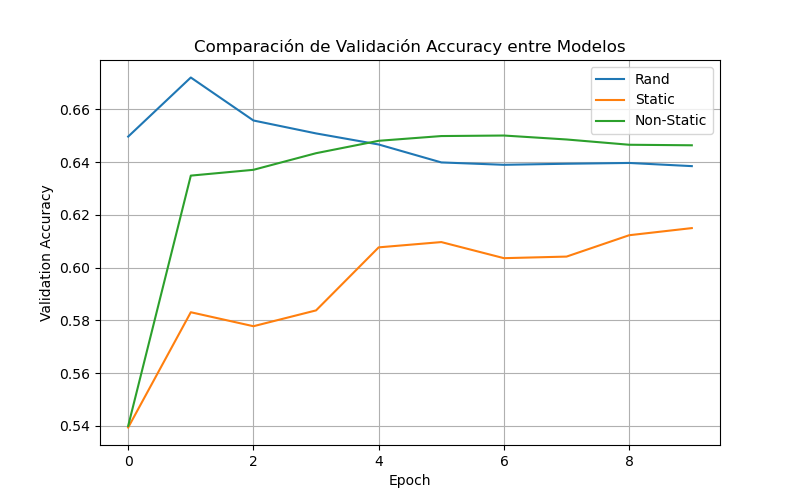

In [121]:
import matplotlib
matplotlib.use('Agg')  # usa backend sin GUI (seguro)

import matplotlib.pyplot as plt

# Extraer val_accuracy de cada modelo
val_acc_rand = history_rand.history['val_accuracy']
val_acc_static = history_static.history['val_accuracy']
val_acc_non_static = history_non_static.history['val_accuracy']

# Crear figura
plt.figure(figsize=(8, 5))

# Graficar cada línea con su etiqueta
plt.plot(val_acc_rand, label='Rand')
plt.plot(val_acc_static, label='Static')
plt.plot(val_acc_non_static, label='Non-Static')

# Añadir detalles al gráfico
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Comparación de Validación Accuracy entre Modelos')
plt.grid(True)
plt.legend()

# Guardar imagen y mostrar
plt.savefig("val_accuracy_comparacion.png")
from IPython.display import Image
Image("val_accuracy_comparacion.png")


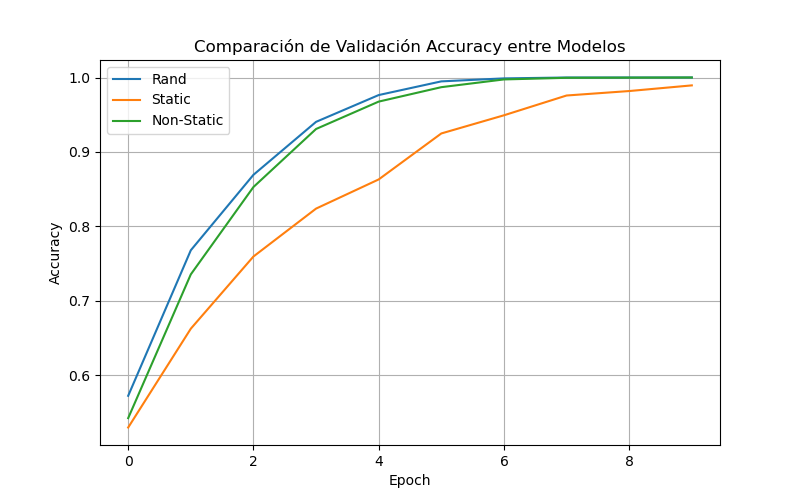

In [122]:
import matplotlib
matplotlib.use('Agg')  # usa backend sin GUI (seguro)

import matplotlib.pyplot as plt

# Extraer val_accuracy de cada modelo
val_acc_rand = history_rand.history['accuracy']
val_acc_static = history_static.history['accuracy']
val_acc_non_static = history_non_static.history['accuracy']

# Crear figura
plt.figure(figsize=(8, 5))

# Graficar cada línea con su etiqueta
plt.plot(val_acc_rand, label='Rand')
plt.plot(val_acc_static, label='Static')
plt.plot(val_acc_non_static, label='Non-Static')

# Añadir detalles al gráfico
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Comparación de Validación Accuracy entre Modelos')
plt.grid(True)
plt.legend()

# Guardar imagen y mostrar
plt.savefig("val_accuracy_comparacion.png")
from IPython.display import Image
Image("val_accuracy_comparacion.png")